# Model comparison

In [1]:
import gurobipy as gb
from gurobipy import GRB
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

## Manage datas

Read the 1000 6x6 instances

In [2]:
networks_df = pd.read_csv("data/d_it_ij_6x6_1000it.csv",
                          decimal=",",
                          header=[0, 1],
                          index_col=0)

# Convert column names from str to int and start counting nodes from 0
networks_df.columns = [networks_df.columns.get_level_values(0).astype(int) - 1,
                       networks_df.columns.get_level_values(1).astype(int) - 1]

# print(networks_df.dtypes)
networks_df.head()


0                   1                             2             \
           6         7         6         7         8         7         8    
it1  1.612014  1.454776  0.376347  1.263488  1.675461  0.383242  1.325470   
it2  0.345666  1.997958  1.022579  1.344409  0.335500  0.768256  0.724642   
it3  1.059043  1.866680  1.672658  0.410748  1.204280  1.351971  1.502285   
it4  0.297746  1.873162  1.144040  1.749892  0.975469  0.168817  0.553882   
it5  1.296527  1.255480  1.777435  1.812928  1.990680  0.990032  0.467010   

                     3             ...        26                  27  \
           9         8         9   ...        32        33        32   
it1  1.502733  0.959483  1.690435  ...  0.199034  1.911133  1.343548   
it2  1.146472  0.726154  0.654525  ...  0.126858  0.794601  1.432874   
it3  0.093011  0.149816  0.665625  ...  1.773551  0.360475  0.016188   
it4  1.758605  1.824679  0.606143  ...  1.398726  1.794652  0.178435   
it5  0.629513  0.962954  0.695574  ...  0.499949  0.563903  0.976726   

                               28                            29            
           33        34        33        34        35        34        35  
it1  0.238743  1.667782  1.273160  0.289610  1.523664  1.968861  1.483620  
it2  0.123810  1.866517  1.411055  1.125656  1.531357  0.725753  0.617501  
it3  1.866432  1.783597  1.205805  0.093973  1.818958  1.471756  1.272506  
it4  0.930916  0.497418  1.837166  1.315127  0.259269  1.973621  1.269510  
it5  1.407947  0.320083  0.168943  0.432240  0.193984  1.377742  0.847393  

[5 rows x 80 columns]

Define simple, but useful classes

In [3]:
class WArc:

    def __init__(self, begin, end, weight, index):
        self.i = begin
        self.j = end
        self.w = weight
        self.idx = index

    def __repr__(self):
        return f"{self.__class__.__name__}({self.i!r}, {self.j!r}, {self.w!r}, {self.idx!r})"


class Agent:

    def __init__(self, source, terminus, index):
        # ? Consider agent name
        self.source = source
        self.terminus = terminus
        self.idx = index
        self.path = None

    def __repr__(self):
        return f"{self.__class__.__name__}({self.source!r}, {self.terminus!r}, {self.idx!r})"


Function that gives a list with all the nodes in the network

In [4]:
def get_nodes(networks_df, fishing_from):

    if fishing_from == "cols":
        starting_nodes = networks_df.columns.get_level_values(0)
        ending_nodes = networks_df.columns.get_level_values(1)
    elif fishing_from == "indx":
        starting_nodes = networks_df.index.get_level_values(0)
        ending_nodes = networks_df.index.get_level_values(1)

    return starting_nodes.union(ending_nodes).unique().tolist()


Functions that gives one by one the network instaces of the dataframe in the form of a list of arcs 

In [5]:
def sixXsix_1000_networks(networks_df):
    for it in networks_df.index:  # each network instance...
        yield [WArc(i, j, networks_df.loc[it, (i, j)], idx)
               for idx, (i, j) in enumerate(networks_df.columns)]  # ... is formed by a set of arcs


## Set up different problems

Functions to build optimization problems 

In [6]:
def compute_flow(X, node, w_arcs, agent):
    flow_out = gb.quicksum(
        X[arc.idx, agent.idx]
        for arc in w_arcs if arc.i == node
    )
    flow_in = gb.quicksum(
        X[arc.idx, agent.idx]
        for arc in w_arcs if arc.j == node
    )
    return flow_out - flow_in


In [7]:
def set_MSPP(nodes, w_arcs, agents):

    MSPP_pb = gb.Model()
    MSPP_pb.setParam("OutputFlag", 0)

    # Decision variables
    X_var_shape = len(w_arcs), len(agents)
    X = MSPP_pb.addMVar(X_var_shape,
                        vtype=GRB.BINARY,  # 5) Binary constraints
                        name="X")

    # 1-3) Objective
    distance_obj = gb.quicksum(
        arc.w * X[arc.idx, agent.idx]
        for arc in w_arcs for agent in agents
    )
    MSPP_pb.setObjectiveN(distance_obj, index=0, weight=1, name="Distance")

    # 4) Flow constraints
    for agent in agents:
        for node in nodes:
            if node == agent.source:
                MSPP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == 1)
            elif node == agent.terminus:
                MSPP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == -1)
            else:
                MSPP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == 0)

    return MSPP_pb, X


In [8]:
def set_ABP(nodes, w_arcs, agents):

    MSPP_PD_ABP_pb, X = set_MSPP(nodes, w_arcs, agents)

    # Additional decision variables
    Psi_var_shape = len(w_arcs)
    Psi = MSPP_PD_ABP_pb.addMVar(Psi_var_shape,
                                 vtype=GRB.BINARY,  # 8) Binary constraints
                                 name="Psi")

    # 6) Additional objective
    penalty_obj = gb.quicksum(
        Psi[arc.idx] for arc in w_arcs
    )
    MSPP_PD_ABP_pb.setObjectiveN(
        penalty_obj, index=1, weight=1, name="Penalty")

    # 7) Additonal constraints
    for arc in w_arcs:
        MSPP_PD_ABP_pb.addConstr(
            1/len(agents) *
            (gb.quicksum(X[arc.idx, agent.idx] for agent in agents) - 1)
            <= Psi[arc.idx]
        )

    return MSPP_PD_ABP_pb, X, Psi


In [9]:
def set_NBP(nodes, w_arcs, agents):

    MSPP_PD_NBP_pb, X = set_MSPP(nodes, w_arcs, agents)

    # Additional decision variables
    R_var_shape = len(nodes), len(agents)
    R = MSPP_PD_NBP_pb.addMVar(R_var_shape,
                               vtype=GRB.BINARY,  # 13) Binary constraints
                               name="R")
    Xi_var_shape = len(nodes)
    Xi = MSPP_PD_NBP_pb.addMVar(Xi_var_shape,
                                vtype=GRB.BINARY,  # 14) Binary constraints
                                name="Xi")

    # 9) Additional objective
    penalty_obj = gb.quicksum(
        Xi[node] for node in nodes
    )
    MSPP_PD_NBP_pb.setObjectiveN(
        penalty_obj, index=1, weight=1, name="Penalty")

    # 10,11) Turning on r_i constraints
    for agent in agents:
        for node in nodes:
            MSPP_PD_NBP_pb.addConstr(
                R[node, agent.idx] >= gb.quicksum(X[arc.idx, agent.idx]
                                                  for arc in w_arcs if arc.i == node)
            )
            MSPP_PD_NBP_pb.addConstr(
                R[node, agent.idx] >= gb.quicksum(X[arc.idx, agent.idx]
                                                  for arc in w_arcs if arc.j == node)
            )

    # 12) Turning on xi_i constraints
    #! Seems weird, the -1 should be outside the summation
    for node in nodes:
        MSPP_PD_NBP_pb.addConstr(
            1/len(agents) * (gb.quicksum(R[node, agent.idx] - 1
                                         for agent in agents))
        )

    return MSPP_PD_NBP_pb, X, R, Xi


In [10]:
def set_problem(problem_type, nodes, w_arcs, agents):
    params = nodes, w_arcs, agents
    if problem_type == "MSPP":
        return set_MSPP(*params)
    elif problem_type == "ABP":
        return set_ABP(*params)
    elif problem_type == "NBP":
        return set_NBP(*params)


## Solve different scenarios

Define variables

In [18]:
num_istances = 5

# problem_types = ["MSPP","ABP", "NBP", "ALP", "NLP", "AQP", "NQP"]
problem_types = ["MSPP", "ABP"]
idx_of_pb_type = dict(zip(problem_types, range(len(problem_types))))

nodes = get_nodes(networks_df,
                  fishing_from="cols")

# scenarios = [3, 6, 9, 12]
scenarios = [3, 6]
idx_of_scenario = dict(zip(scenarios, range(len(scenarios))))

agents_sources = [0, 1, 2, 3, 4, 5, 0, 2, 4, 1, 3, 5]
source_of_agent = dict(zip(range(0, len(agents_sources)), agents_sources))

agents_terminus = [node + 30 for node in agents_sources]
terminus_of_agent = dict(zip(range(0, len(agents_terminus)), agents_terminus))

# TODO: Directly use dataframe to store datas (?)
# opt_tot_distances = np.zeros(
#     (len(problem_types), len(scenarios), num_istances))
opt_tot_distances = np.zeros( (num_istances, len(problem_types), len(scenarios)) )
# agent_opt_distances = np.full((len(problem_types), len(scenarios), 12, num_istances),
#                               fill_value=np.nan)
agent_opt_distances = np.full( (12, num_istances, len(problem_types), len(scenarios)),
                              fill_value=np.nan)


Useful functions to analyze problems and their results 

In [12]:
def evaluate_pb_objectives(problem):

    # ? Shold I check optimality
    # * See: https://www.gurobi.com/documentation/9.5/refman/working_with_multiple_obje.html

    problem.params.SolutionNumber = 0  # Set best solution found
    opt_solution = []

    # Add to opt_solution the value of each objective
    for obj in range(problem.NumObj):
        problem.params.ObjNumber = obj
        opt_solution.append(problem.ObjNVal)

    return opt_solution


def evaluate_agent_distance(X, w_arcs, agent):
    # ? Should I check that nodes in arcs == nodes in X_values
    return sum(arc.w for arc in w_arcs if math.isclose(X.x[arc.idx, agent.idx], 1))


Solve each case

In [25]:
# for each network istance...
for it_i, network_arcs in enumerate(sixXsix_1000_networks(networks_df.head(num_istances))):
    for pb_type in problem_types:  # ...and for each type of problem...
        for num_of_agents in scenarios:  # ...solve a particular scnario

            agents = [Agent(source_of_agent[i], terminus_of_agent[i], index=i)
                      for i in range(num_of_agents)]

            pb, X, *_ = set_problem(pb_type, nodes, network_arcs, agents)
            pb.optimize()

            opt_tot_distance, *_ = evaluate_pb_objectives(pb)
            opt_tot_distances[it_i,
                              idx_of_pb_type[pb_type],
                              idx_of_scenario[num_of_agents]] = opt_tot_distance

            for agent in agents:
                agent_opt_distances[agent.idx,
                                    it_i,
                                    idx_of_pb_type[pb_type],
                                    idx_of_scenario[num_of_agents]] = evaluate_agent_distance(X, network_arcs, agent)


## Final statistics

In [27]:
mean_opt_tot_distance = np.mean(opt_tot_distances, axis=0)

mean_opt_tot_distance_df = pd.DataFrame(mean_opt_tot_distance,
                                        columns=scenarios,
                                        index=problem_types)
mean_opt_tot_distance_df


,3,6
MSPP,8.721362,16.661043
ABP,9.253758,18.233682


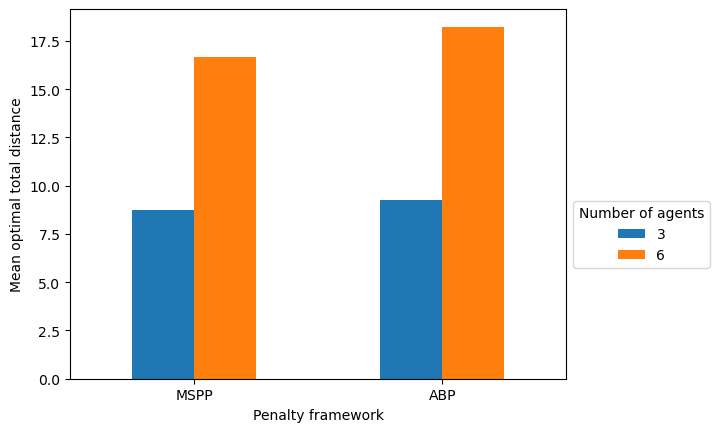

In [28]:
ax = mean_opt_tot_distance_df.plot.bar(rot=0,
                                      xlabel="Penalty framework",
                                      ylabel="Mean optimal total distance")
ax.legend(title="Number of agents",
          bbox_to_anchor=(1, 0.5))


In [31]:
avg_agents_opt_distances = np.nanmean(agent_opt_distances, axis=(0, 1))

avg_agennts_opt_distances_df = pd.DataFrame(avg_agents_opt_distances.T,
                                            columns=problem_types,
                                            index=scenarios)

avg_agennts_opt_distances_df.head()


,MSPP,ABP
3,2.907121,3.106718
6,2.776841,3.038947
